In [6]:
from pydub import AudioSegment
from scipy import signal
from sklearn.utils import shuffle
import re
import pandas as pd
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import librosa
from librosa import display
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Embedding, Activation
from keras.layers import Conv1D, Conv2D, MaxPooling2D, ConvLSTM2D, LSTM, Bidirectional, GRU, TimeDistributed
from keras.optimizers import *
from keras.engine.input_layer import Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import itertools
import math
import time
import os
import json

C:\Users\Emmanuel\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [7]:
num_classes = 5
data_path = "depression-detection-extract/data/raw/transcripts/"
audio_path = "depression-detection-extract/data/raw/audio/"

In [8]:
SR = 22050
def get_short_time_fourier_transform(soundwave):
    return librosa.stft(soundwave, n_fft=256)

def short_time_fourier_transform_amplitude_to_db(stft):
    return librosa.amplitude_to_db(stft)

def soundwave_to_np_spectrogram(soundwave):
    step1 = get_short_time_fourier_transform(soundwave)
    step2 = short_time_fourier_transform_amplitude_to_db(step1)
    step3 = step2/100
    return step3

def inspect_data(sound):
    a = get_short_time_fourier_transform(sound)
    Xdb = short_time_fourier_transform_amplitude_to_db(a)
    return Xdb

In [9]:
def confusion_matrix(model, x, y):
    prediction = model.predict(x, batch_size=None, verbose=0, steps=None)
    labels=['none','mild','moderate','moderately severe', 'severe']

    max_prediction = np.argmax(prediction, axis=1)
    max_actual = np.argmax(y, axis=1)

    y_pred = pd.Categorical.from_codes(max_prediction, labels)
    y_actu = pd.Categorical.from_codes(max_actual, labels)

    return pd.crosstab(y_actu, y_pred)

In [10]:
def load_avec_dataset_file(path, score_column):
    ds = pd.read_csv(path, sep=',')
    ds['level'] = pd.cut(ds[score_column], bins=[-1,0,5,10,15,25], labels=[0,1,2,3,4])
    ds['PHQ8_Score'] = ds[score_column]
    ds['cat_level'] = keras.utils.to_categorical(ds['level'], num_classes).tolist()
    ds = ds[['Participant_ID', 'level', 'cat_level', 'PHQ8_Score']]
    ds = ds.astype({"Participant_ID": float, "level": int, 'PHQ8_Score': int})
    return ds

In [11]:
train = load_avec_dataset_file('depression-detection-extract/data/train_split_Depression_AVEC2017.csv', 'PHQ8_Score')
dev = load_avec_dataset_file('depression-detection-extract/data/dev_split_Depression_AVEC2017.csv', 'PHQ8_Score')
test = load_avec_dataset_file('depression-detection-extract/data/full_test_split.csv', 'PHQ_Score')
print("Size: train= {}, dev= {}, test= {}".format(len(train), len(dev), len(test)))
train.head()

Size: train= 107, dev= 35, test= 47


,Participant_ID,level,cat_level,PHQ8_Score
0,303.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0
1,304.0,2,"[0.0, 0.0, 1.0, 0.0, 0.0]",6
2,305.0,2,"[0.0, 0.0, 1.0, 0.0, 0.0]",7
3,310.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",4
4,312.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",2


### Audio segmentation & speaker diarization

In [12]:
ds_total = pd.concat([train,dev,test])
total_phq8 = len(ds_total)
print("Total size = {}".format(total_phq8))

Total size = 189


In [13]:
ds_total.to_csv(data_path + 'ds_total.csv', sep='\t')
print("File was created")

File was created


In [14]:
def segment_audio(ds_total, transcript_directory, audio_directory, audio_output_dir):
    input_array = []
    person_id_list = []
    level_array = []
    
    filenames = os.listdir(transcript_directory)
    
    if ".DS_Store" in filenames:
        filenames.remove(".DS_Store")
        
    for filename in filenames:
        transcript_path = os.path.join(transcript_directory, filename)
        transcript = pd.read_csv(transcript_path, sep='\t')
        m = re.search("(\d{3})_TRANSCRIPT.csv", filename)
        if m:
            person_id = int(m.group(1))            
            person_audio = AudioSegment.from_wav(audio_directory 
                                             + str(person_id) + '_AUDIO.wav')
            lines = len(transcript)
            combined_sounds = AudioSegment.empty()
            for i in range(0, lines):
                row = transcript.iloc[i]
                if row["speaker"] == "Participant":
                    t1 = int(float(row["start_time"]) * 1000)
                    t2 = int(float(row["stop_time"]) * 1000)
                    newAudio = person_audio[t1:t2]
                    combined_sounds += newAudio
                    
            combined_sounds.export(audio_output_dir + str(person_id) + '.wav', format="wav")

            w = AudioSegment.from_wav(audio_output_dir + str(person_id) + '.wav')
            input_array.append(w)
            person_id_list.append(person_id)
            level_array.append(ds_total.loc[ds_total["Participant_ID"] == person_id, "level"].item())
    print(f"Segmentation complete!")
            
    return input_array, person_id_list, level_array

In [15]:
input_array, person_id_list, level_array = segment_audio (ds_total, data_path , audio_path, "depression-detection-extract/data/segmented_audio/")


Segmentation complete!


In [16]:
len_list = []
for audio_file in input_array:
    len_list.append(int(len(audio_file) / (1000)))

In [17]:
# print("\n",input_array)
# print("\n",person_id_list)
# print("\n",level_array)

len_list = []
for audio_file in input_array:
    len_list.append(int(len(audio_file) / (1000)))

### Creating audio samples each 7sec long for each diarized recording

In [18]:
person_id_list_extended = []
trim_array = []
level_array_extended = []
stride = 15
time_window = 7
n_samples_max = 10

path = "depression-detection-extract/data/audio_augmented/time_window_" + str(time_window) + "_stride_" + str(stride) + "_max_" + str(n_samples_max) +"/"

if not os.path.exists(path):
    os.makedirs(path)

for audio_file, person_id, level in zip(input_array, person_id_list, level_array):  
    n_samples = min(n_samples_max, int((len(audio_file) - time_window * 1000)/(stride * 1000)))
    t1_ini = 0
    t2_end = time_window * 1000
    for i in range(n_samples):
        t1_ini = t1_ini + stride * 1000
        t2_end = t2_end + stride * 1000
        audio_trim = audio_file[t1_ini:t2_end]
        trim_array.append(audio_trim)
        person_id_list_extended.append(person_id)
        level_array_extended.append(level)
        audio_trim.export(path + str(person_id) + '_' + str(i) + '.wav', format="wav")

In [19]:
len(trim_array)

309

In [20]:
person_id_list_padded = []
padded_array = []
level_array_padded = []
max_size = max(len_list)
mean_size = np.mean(len_list)
min_size = min(len_list)
for audio_file, person_id, level in zip(input_array, person_id_list, level_array):  
    padding = AudioSegment.silent(duration = min_size * 1000)
    audio_trim = padding.overlay(audio_file)
    padded_array.append(audio_trim)
    person_id_list_padded.append(person_id)
    level_array_padded.append(level)
    audio_trim.export("depression-detection-extract/data/audio_cut_padded/mean/" + str(person_id) + '.wav', format="wav")


In [21]:
# Read the audio sample and calculate the normalized spectrogram

X, sr = librosa.load(path + '303' + '_' + '1' + '.wav')
sample = soundwave_to_np_spectrogram(X)
sample = sample[0:95,:]
sample.shape

C:\Users\Emmanuel\anaconda3\lib\site-packages\librosa\core\spectrum.py:1641: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn(


(95, 2412)

In [22]:
sample.size

229140

In [23]:
X, sr = librosa.load('depression-detection-extract/data/audio_cut_padded/mean/' + '303' + '.wav')
sample = soundwave_to_np_spectrogram(X)

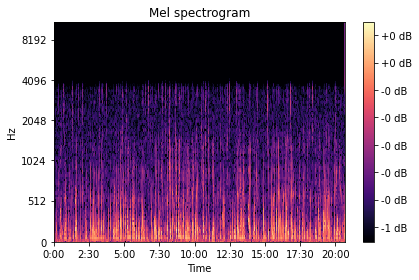

In [24]:
# Show the spectrogram

librosa.display.specshow(sample,
                         y_axis='mel',
                         x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [25]:
def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)

In [26]:
dataset_path = path
filenames = os.listdir(dataset_path)

if ".DS_Store" in filenames:
    filenames.remove(".DS_Store")

sort_nicely(filenames)
Xdb = []    
    
for filename in filenames:
    X, sr = librosa.load(dataset_path + filename)
    X = abs(soundwave_to_np_spectrogram(X))
    X = X[0:95,:]
    Xdb.append(X)

In [27]:
spec_path = "depression-detection-extract/data/spectrogram/audio_augmented/time_window_" + str(time_window) + "_stride_" + str(stride) + "_max_" + str(n_samples_max) + "/"

if not os.path.exists(spec_path):
    os.makedirs(spec_path)

np.asarray(Xdb).dump(open(spec_path +"Xdb.npy", "wb"))
np.asarray(level_array_extended).dump(open(spec_path + 'Y.npy', 'wb'))

In [28]:
number_of_files = int(len(Xdb)/500)
for i in range(number_of_files):
    start = i * 500
    end = start + 500 if start + 500 < len(Xdb) else len(Xdb)
    np.asarray(Xdb[start:end]).dump(open('depression-detection-extract/data/spectrogram/audio_augmented/time_window_10_stride_10_max_10/Xdb_' + str(i) + '.npy', 'wb'))
    np.asarray(level_array_extended[start:end]).dump(open('depression-detection-extract/data/spectrogram/audio_augmented/time_window_10_stride_10_max_10/Y_' + str(i) + '.npy', 'wb'))

In [29]:
'''Xdb = np.load(open('depression-detection-extract/data/spectrogram/audio_augmented/time_window_10_stride_10_max_10/Xdb.npy', 'rb'))'''


"Xdb = np.load(open('depression-detection-extract/data/spectrogram/audio_augmented/time_window_10_stride_10_max_10/Xdb.npy', 'rb'))"

In [30]:
# Size of the spectrogram. Every sample has the same length so only 1 size is calculated.

alto, ancho = Xdb[0].shape
print(alto, ancho)

95 2412


In [31]:
level_array_extended_new = np.asarray(level_array_extended)
print(np.asarray(Xdb).shape)
print(level_array_extended_new.shape)
len(Xdb)

(309, 95, 2412)
(309,)


309

In [32]:
def split_by_phq_level(ds):
    none_ds = ds[ds['level']==0]
    mild_ds = ds[ds['level']==1]
    moderate_ds = ds[ds['level']==2]
    moderate_severe_ds = ds[ds['level']==3]
    severe_ds = ds[ds['level']==4]
    return (none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds)

np.unique(level_array_extended_new, return_counts=True)


(array([0, 1, 2, 3, 4]), array([ 20, 159,  60,  40,  30], dtype=int64))

In [33]:
def distribute_levels(Xdb, level_array):
    Xdb_shuffled, level_array_shuffled = shuffle(Xdb, level_array, random_state=0)
    
    levels, counts = np.unique(level_array, return_counts=True)
    n_levels = len(levels)
    
    
    X = [None] * n_levels
    Y = [None] * n_levels
       
    for i in levels:
        X[i] = np.compress(level_array_shuffled == i, Xdb_shuffled, axis = 0)
        Y[i] = [i] * counts[i]
    
    X = np.array(X)
    Y = np.array(Y)

    return X, Y, levels, counts

X, Y, levels, counts = distribute_levels(Xdb, level_array_extended_new)


In [34]:
def distribute_sets(X, Y, levels, counts, split = [70,14,16]): 
    
    n_levels = len(levels)
        
    X_dict = dict()
    Y_dict = dict()
    
    last = np.zeros(n_levels)
    prev = np.zeros(n_levels)
   
    for p in split:
        X_dict['d'+str(p)] = []
        Y_dict['d'+str(p)] = []
        for i in levels:
            last[i] = min(counts[i], prev[i] + round(counts[i] * p /100.))
       
        X_dict['d'+str(p)] = np.concatenate([X[i][int(prev[i]):int(last[i])] for i in levels], axis = 0)
        Y_dict['d'+str(p)] = np.concatenate([Y[i][int(prev[i]):int(last[i])] for i in levels], axis = 0)
        
        prev = last.copy()
        
        
    return (X_dict['d70'], Y_dict['d70'], X_dict['d14'], Y_dict['d14'], X_dict['d16'], Y_dict['d16'])

In [79]:
X_train, Y_train, X_dev, Y_dev, X_test, Y_test = distribute_sets(X, Y, levels, counts)

X_test.shape, X_train.shape
# print(X_test)

((49, 95, 2412), (216, 95, 2412))

In [36]:
def reshape_to_cnn(X):
    X_reshape = np.asarray(X.reshape(X.shape[0], X.shape[1], X.shape[2], 1))
    return X_reshape

In [37]:
X_train_cnn = reshape_to_cnn(X_train)
X_dev_cnn = reshape_to_cnn(X_dev)
X_test_cnn = reshape_to_cnn(X_test)

Y_train_oh = keras.utils.to_categorical(Y_train)
Y_dev_oh = keras.utils.to_categorical(Y_dev)
Y_test_oh = keras.utils.to_categorical(Y_test)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [74]:
print(X_test_cnn.shape)

(49, 95, 2412, 1)


In [38]:
X_train.shape

(216, 95, 2412)

In [39]:
def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    # Step 1: CONV layer 
    X = Dropout(rate = 0.2)(X_input) 
    X = Conv1D(filters = 100, kernel_size = 2, strides=1)(X)                              # CONV1D
    X = BatchNormalization(axis=-1)(X)                                 # Batch normalization
    X = Activation('relu')(X)                                 # ReLu activation
    X = Dropout(rate = 0.4)(X)                                 # dropout (use 0.8)

    # Step 2: First GRU Layer
    X = GRU(units = 100, return_sequences = True)(X)                                # GRU (use 128 units and return the sequences)
    X = Dropout(rate = 0.4)(X)                                 # dropout (use 0.8)
    X = BatchNormalization(axis=-1)(X)                                 # Batch normalization
    
    # Step 3: Second GRU Layer
    X = GRU(units = 100, return_sequences = False)(X)                                  # GRU (use 128 units and return the sequences)
    X = Dropout(rate = 0.4)(X)                                 # dropout (use 0.8)
    X = BatchNormalization(axis=-1)(X)                                 # Batch normalization
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = Dense(5, activation = "softmax")(X) # sigmoid

    model = Model(inputs = X_input, outputs = X)
    
    return model

In [77]:
X_train.shape

(216, 95, 2412)

In [40]:
model = model(input_shape = X_train[0].shape)
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 95, 2412)]        0         
_________________________________________________________________
dropout (Dropout)            (None, 95, 2412)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 94, 100)           482500    
_________________________________________________________________
batch_normalization (BatchNo (None, 94, 100)           400       
_________________________________________________________________
activation (Activation)      (None, 94, 100)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 94, 100)           0         
_________________________________________________________________
gru (GRU)                    (None, 94, 100)          

In [41]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])


In [42]:
model_2gru_hist = model.fit(X_train, Y_train_oh, validation_data=(X_dev, Y_dev_oh), epochs = 30, batch_size = 64, shuffle = True, callbacks=[early_stopping])

Epoch 1/30
4/4 [==============================] - 8s 2s/step - loss: 2.1951 - accuracy: 0.2037 - val_loss: 1.9762 - val_accuracy: 0.0930
Epoch 2/30
4/4 [==============================] - 3s 826ms/step - loss: 2.2010 - accuracy: 0.2083 - val_loss: 2.0817 - val_accuracy: 0.0930
Epoch 3/30
4/4 [==============================] - 3s 722ms/step - loss: 2.2028 - accuracy: 0.2361 - val_loss: 2.0254 - val_accuracy: 0.0930
Epoch 4/30
4/4 [==============================] - 3s 871ms/step - loss: 1.9942 - accuracy: 0.2731 - val_loss: 1.9827 - val_accuracy: 0.1163
Epoch 5/30
4/4 [==============================] - 2s 605ms/step - loss: 1.9734 - accuracy: 0.2546 - val_loss: 1.9412 - val_accuracy: 0.1163
Epoch 6/30
4/4 [==============================] - 3s 697ms/step - loss: 1.9790 - accuracy: 0.2407 - val_loss: 1.9255 - val_accuracy: 0.1395
Epoch 7/30
4/4 [==============================] - 2s 617ms/step - loss: 1.9122 - accuracy: 0.3009 - val_loss: 1.8696 - val_accuracy: 0.1395
Epoch 8/30
4/4 [=======

In [43]:
# print(model_2gru_hist.history)

with open('depression-detection-extract/models/model_2gru_hist.json', 'w') as f:
    json.dump(model_2gru_hist.history, f)
model.save('depression-detection-extract/models/model_2gru.h5')

In [44]:
score = model.evaluate(X_test, Y_test_oh, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.6099563837051392
Test accuracy: 0.5102040767669678


In [45]:
from sklearn import metrics

Y_predict = model.predict(X_test) 
confusionmatrix = metrics.confusion_matrix(Y_test_oh.argmax(axis=1), Y_predict.argmax(axis=1))
print(confusionmatrix)

[[ 0  3  0  0  0]
 [ 0 24  0  0  1]
 [ 0 10  0  0  0]
 [ 0  6  0  0  0]
 [ 0  4  0  0  1]]


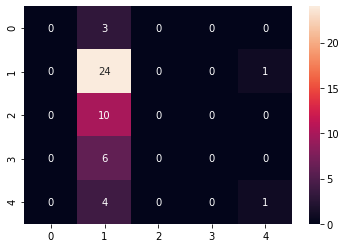

In [46]:
import seaborn as sns
sns.heatmap(confusionmatrix, annot=True)

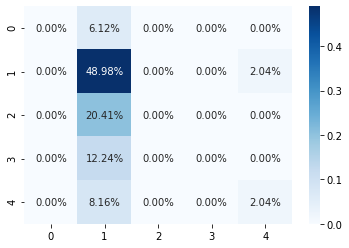

In [47]:
sns.heatmap(confusionmatrix/np.sum(confusionmatrix), annot=True, fmt='.2%', cmap='Blues')

In [48]:
def model_cnn(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    # Step 1: CONV2D layer 
    X = Conv2D(filters = 50, kernel_size = (5,5), strides=(1, 4), padding='same', data_format="channels_last", activation='relu')(X_input)      # CONV2D
    X = MaxPooling2D(pool_size=(2, 4))(X)
    X = BatchNormalization(axis=-1)(X)                                 # Batch normalization
    X = Dropout(rate = 0.4)(X)                                 # dropout 

    # Step 2: CONV2D Layer
    X = Conv2D(filters = 100, kernel_size = (5,5), strides=(1, 2), padding='same', data_format="channels_last", activation='relu')(X)      # CONV2D
    X = MaxPooling2D(pool_size=(2, 3))(X)
    X = BatchNormalization(axis=-1)(X)                                 # Batch normalization
    X = Dropout(rate = 0.4)(X)                                 # dropout 
    
#     # Step 3: CONV2D Layer
#     X = Conv2D(filters = 128, kernel_size = (3,3), strides=(1, 1), padding='same', data_format="channels_last", activation='relu')(X)      # CONV2D
#     X = MaxPooling2D(pool_size=(2, 3))(X)
#     X = BatchNormalization(axis=-1)(X)                                 # Batch normalization
#     X = Dropout(rate = 0.4)(X)   # dropout 
    
#     # Step 4: CONV2D Layer
#     X = Conv2D(filters = 250, kernel_size = (3,3), strides=(1, 1), padding='same', data_format="channels_last", activation='relu')(X)      # CONV2D
#     X = MaxPooling2D(pool_size=(2, 2))(X)
#     X = BatchNormalization(axis=-1)(X)                                 # Batch normalization
#     X = Dropout(rate = 0.2)(X)   # dropout 
    
    # Step 4: Flatten and dense layer
    X = Flatten()(X)
    X = Dense(5, activation = "relu")(X)
    X = Dense(5, activation = "softmax")(X)

    model = Model(inputs = X_input, outputs = X)
    
    return model

In [49]:
model_cnn = model_cnn(input_shape = X_train_cnn[0].shape)
model_cnn.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 95, 2412, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 95, 603, 50)       1300      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 150, 50)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 47, 150, 50)       200       
_________________________________________________________________
dropout_4 (Dropout)          (None, 47, 150, 50)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 75, 100)       125100    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 25, 100)      

In [50]:
model_cnn.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

# log best model
checkpoint_best     = ModelCheckpoint('model_cnn_best',   monitor='loss', verbose=0, save_best_only=True, mode='auto')

# log improved model
checkpoint_epochs   = ModelCheckpoint('model_cnn_epochs', monitor='loss', verbose=0, save_best_only=True, mode='auto')

In [51]:
model_cnn_hist = model_cnn.fit(
    X_train_cnn, Y_train_oh, validation_data=(
        X_dev_cnn, Y_dev_oh), epochs = 10, batch_size = 64, shuffle = True, callbacks=[
        early_stopping, checkpoint_best, checkpoint_epochs
    ]
)

Epoch 1/10
4/4 [==============================] - ETA: 0s - loss: 2.2503 - accuracy: 0.3611 - ETA: 23s - loss: 2.3306 - accuracy: 0.333WARNING:tensorflow:From C:\Users\Emmanuel\anaconda3\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_cnn_best\assets
INFO:tensorflow:Assets written to: model_cnn_epochs\assets
4/4 [==============================] - 223s 56s/step - loss: 2.2503 - accuracy: 0.3611 - val_loss: 1.6072 - val_accuracy: 0.4186
Epoch 2/10
4/4 [==============================] - ETA: 0s - loss: 1.5929 - accuracy: 0.5093 INFO:tensorflow:Assets written to: model_cnn_best

In [52]:
score = model_cnn.evaluate(X_test_cnn, Y_test_oh, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.5874887704849243
Test accuracy: 0.5102040767669678


In [53]:
Y_predict = model_cnn.predict(X_test_cnn) 
confusionmatrix = metrics.confusion_matrix(Y_test_oh.argmax(axis=1), Y_predict.argmax(axis=1))
print(confusionmatrix)

# 0 = none, 1 = moderate, 2 = moderately severe, 3 = severe

[[ 0  3  0  0  0]
 [ 0 25  0  0  0]
 [ 0 10  0  0  0]
 [ 0  6  0  0  0]
 [ 0  5  0  0  0]]


In [89]:
new_Ytest = Y_test.astype(int)

In [90]:
new_Ytest

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 4])

In [54]:
Y_predict.shape


(49, 5)

In [55]:
print(X_test_cnn)
print(X_test_cnn.shape)

[[[[0.1846595 ]
   [0.16511181]
   [0.30628806]
   ...
   [0.12701191]
   [0.18534477]
   [0.1057104 ]]

  [[0.22757526]
   [0.25142682]
   [0.13884239]
   ...
   [0.07899508]
   [0.14059791]
   [0.10637975]]

  [[0.254209  ]
   [0.23977485]
   [0.1266913 ]
   ...
   [0.06746898]
   [0.07068444]
   [0.10127655]]

  ...

  [[0.602483  ]
   [0.662659  ]
   [0.70169294]
   ...
   [0.70169294]
   [0.70169294]
   [0.5988713 ]]

  [[0.60175097]
   [0.66126275]
   [0.70169294]
   ...
   [0.70169294]
   [0.70169294]
   [0.60249096]]

  [[0.6031551 ]
   [0.6633384 ]
   [0.70169294]
   ...
   [0.70169294]
   [0.70169294]
   [0.60586196]]]


 [[[0.09819605]
   [0.11485557]
   [0.14898452]
   ...
   [0.10306196]
   [0.15514947]
   [0.22236383]]

  [[0.15142599]
   [0.15926903]
   [0.23766449]
   ...
   [0.19566993]
   [0.13486654]
   [0.19090582]]

  [[0.3975737 ]
   [0.27234033]
   [0.30063316]
   ...
   [0.02301736]
   [0.02166098]
   [0.04817302]]

  ...

  [[0.59547645]
   [0.6564805 ]
   [0.7

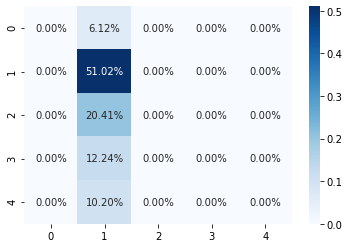

In [56]:
sns.heatmap(confusionmatrix/np.sum(confusionmatrix), annot=True, fmt='.2%', cmap='Blues')

In [57]:
# print(Y_predict)
predicted_classes = np.argmax(np.round(Y_predict),axis=1)
print(predicted_classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]


In [58]:
predicted_classes.shape, Y_test_oh.shape

((49,), (49, 5))

### Number of correct & incorrect labels

In [59]:
correct = np.where(predicted_classes==Y_test_oh)[0]
print("Found %d correct labels" % len(correct))
# for i, correct in enumerate(correct[:9]):
#     plt.subplot(3,3,i+1)
#     plt.imshow(X_test_cnn[correct].reshape(28,28), cmap='gray', interpolation='none')
#     plt.title("Predicted {}, Class {}".format(predicted_classes[correct], Y_predict[correct]))
#     plt.tight_layout()

Found 0 correct labels


<ipython-input-59-4bba1e5aac5c>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct = np.where(predicted_classes==Y_test_oh)[0]


In [60]:
incorrect = np.where(predicted_classes!=Y_test_oh)[0]
print("Found %d incorrect labels" % len(incorrect))
# for i, incorrect in enumerate(incorrect[:9]):
#     plt.subplot(3,3,i+1)
#     plt.imshow(X_test_cnn[incorrect].reshape(28,28), cmap='gray', interpolation='none')
#     plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], Y_test_oh[incorrect]))
#     plt.tight_layout()

Found 1 incorrect labels


<ipython-input-60-9a086e508f57>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  incorrect = np.where(predicted_classes!=Y_test_oh)[0]


In [61]:
with open('depression-detection-extract/models/model_cnn_hist.json', 'w') as f:
    json.dump(model_cnn_hist.history, f)
model_cnn.save('depression-detection-extract/models/model_cnn.h5')

In [62]:
print(model_cnn_hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [63]:
def plot_acc(history=model_cnn_hist, title="Model Accuracy"):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1", name2="Red 2", title="Losses Comparison"):
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Accuracy Comparison"):
    """Compare Accuracies of Two Trainings with Names Name1 and Name2"""
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

def plot_compare_multiple_metrics(history_array, names, colors, title="Multiple metrics", metric='accuracy'):  
    legend = []
    for i in range(0, len(history_array)):
        plt.plot(history_array[i].history[metric], color=colors[i])
        plt.plot(history_array[i].history['val_' + metric], 'r--', color=colors[i])
        legend.append('Train ' + names[i])
        legend.append('Val ' + names[i])
    
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')   
    plt.axis
    plt.legend(legend, 
               loc='lower right')
    plt.show()

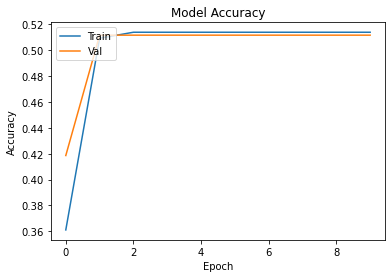

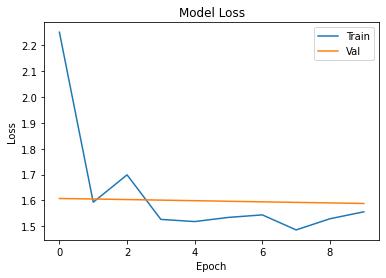

In [64]:
plot_acc(model_cnn_hist)
plot_loss(model_cnn_hist)

In [ ]:
plot_compare_losses(model_2gru_hist, model_cnn_hist)

In [ ]:
plot_compare_accs(model_2gru_hist, model_cnn_hist)

In [ ]:
plot_compare_multiple_metrics([model_2gru_hist], names=["1", "2", "3", "4"], colors=["purple"])

### Converting model to tflite format (for use on mobile)

In [114]:
from tensorflow import lite

converter = lite.TFLiteConverter.from_keras_model(model_cnn)
tfmodel = converter.convert()
open("depression-detection-extract/models/model.tflite", "wb").write(tfmodel)


INFO:tensorflow:Assets written to: C:\Users\Emmanuel\AppData\Local\Temp\tmp7a2bnmra\assets


1661216

### Reloading the model to test it

In [93]:
loaded_model = keras.models.load_model('depression-detection-extract/models/model_cnn.h5')
loaded_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 95, 2412, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 95, 603, 50)       1300      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 150, 50)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 47, 150, 50)       200       
_________________________________________________________________
dropout_4 (Dropout)          (None, 47, 150, 50)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 75, 100)       125100    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 25, 100)      

In [96]:
loss, acc = loaded_model.evaluate(X_test_cnn, Y_test_oh)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

2/2 [==============================] - 1s 380ms/step - loss: 1.5875 - accuracy: 0.5102
Restored model, accuracy: 51.02%


In [112]:
from tensorflow import lite
import tensorflow as tf

converter = lite.TFLiteConverter.from_keras_model('model_cnn.h5') # Your model's name
model = converter.convert()
file = open('model.tflite' , 'wb') 
file.write( model )

AttributeError: 'str' object has no attribute 'call'